# Perform Cyclic Pushover Analysis of an Experimentally Tested Reinforced Concrete Column 
<br></br>
* **Description** - This project is designed to develop and validate a generalised finite model of an RC column with experimental data. 
<br></br>

## Key Learnings
1. In detail knowledge about creating the RC section using fiber section concept of OpenSeesPy and visualising the created section. 
2. How to download experimental data of columns testted under a variety of scenarios from PEER and use it in your projects. 
3. How to process the cyclic load displacement data and extract the displacement data for performing a displacement controlled simulation? 
4. In details knowledge about various stages involved in creating FE model and post processing hte load displacement result. 
<br></br>

## Problem Description and Data
  Link to experimental details : https://nisee.berkeley.edu/spd/servlet/display?format=html&id=106
<br></br>

  


In [28]:
# chek if openseespy is installed in the system

#python -m pip install openseespy
#python -m pip install opsvis
#python -m pip show matplotlib
#python -m pip show numpy
#python -m pip install plotly
#python -m pip install ipynb
#python -m pip install pandas --user


### Import Necessary Modules


In [29]:
import openseespy.opensees as os
import opsvis as osv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as pg
#from ipynb.fs.defs.disp_profile_generation import dispProfile


### Geometric and Material Details

In [30]:
# === Unit Convention
mm = 1
N = 1
Pa = 1

m = 1000 * mm

inches = 0.0254 * m
ft = 12 * inches
kip = 4.45 * 10**3 * N
ksi = 6.89 * 10**6 * Pa

kN = 1000 * N
tonf = 9.80665 * kN

MPa = 10**6 * Pa
GPa = 10**9 * Pa

nDim = 2 # number of Dimension 
nDof = 3 # number of dofs per node
nEle = 5 # designated number of elements

L = 1000*mm
B = 0.35*m
D = 0.35*m
A = L*B
E = 2.e5 * N/(mm**2)
Iz = B*(D**3)/12*(mm**4)

# === Load sign convention 
#  Vertical : +ve sign represents bottom to top 
#  Horizontal : +ve sign represents left to right 

VLoad = -600*kN 
HLoad = 1 # unit lateral reference load (also act as load factor)

# === Mesh Data Generation 
numNodes = nEle + 1 
nCoords = np.zeros([numNodes, nDim])  # 0-xcoord 1-ycoord
eleTags = []
nodeTags = []

# Nodal Data Generation 
for i in range(0,numNodes):  # range from 0 to (numNodes-1)
    nCoords[i,0]=0.0 # xcoord
    nCoords[i,1]=i*(L/nEle) # ycoord
    nodeTags.append(i+1)
    
# Element Data Generation 
for i in range(0,nEle):
    eleTags.append(i+1)

## Preprocessing 
### OpenSees Model Generation 
### Node, Section, Material and Element Definitions

In [31]:
# === General Model Setting 
os.wipe() # Cleans the existing database of nodes, materials, elements, recorders etc
os.model('basic','-ndm',2,'-ndf',3)  # This is a 2D model with 2 translational and 1 rotational dofs pernode

# Node Generation 
for i  in range(0,numNodes):
    os.node(nodeTags[i],nCoords[i,0],nCoords[i,1])
    
# === Uniaxial material definition 
#     For uniaxial material the syntax is uniaxialMaterial

Fy=438*mm
b=0.01      #strain hardening coefficient of steel 

FpcUncon = -32*MPa            # Compressive strength of unconined concrete (-ve concrete)
epsc0Uncon=-0.003             # Strain at maximum strength of unconfined concrete
FpcUUncon = 0.25*FpcUncon     # Concrete crushing strength 
epsUUncon = -0.01            # concrete strain at crushing strength 

ConToUnconRatio = 1.3 

FpcCon = FpcUncon*ConToUnconRatio     # Compressive strength of unconfined concrete (-ve compression)
epsc0Con = epsc0Uncon*ConToUnconRatio # Strain at maximum strength of unconfined concrete 
FpcUCon = FpcUUncon*ConToUnconRatio   # Concrete crushing strength 
epsUCon =  epsUUncon*ConToUnconRatio # Concrete strain at crushing strength 

ConConTag = 1
UnConConcTag = 2 
SteelTag = 3

# Concrete01 (https://openseespydoc.readthedocs.io/en/latest/src/Concrete01.html)
# Steel01 (https://openseespydoc.readthedocs.io/en/latest/src/steel01.html)

os.uniaxialMaterial('Concrete01', ConConTag, FpcUncon, epsc0Uncon, FpcUUncon, epsUUncon)
os.uniaxialMaterial('Concrete01', UnConConcTag, FpcCon, epsc0Con, FpcUCon, epsUCon)
os.uniaxialMaterial('Steel01',SteelTag,Fy,E,b)

Cover = 40*mm      # In all directions
B1 = B/2
B1c = B1 - Cover
D1 = D/2 
D1c = D1 - Cover

LongBarDia = 25*mm
LongBarArea = (np.pi)*(LongBarDia**2)/4

# === Quadrilateral Patch (https://opensees.berkeley.edu/wiki/index.php/Patch_Command)
# Straight Layer (https://opensees.berkeley.edu/OpenSees/manuals/usermanual/223.htm)

secTag = 1 # Fiber section tag
fibSec_1 = [['section', 'Fiber',secTag, '-GJ', 0.0],
            ['patch', 'quad', ConConTag, 4,4,*[-D1c,B1c],*[-D1c,-B1c],*[D1c,-B1c],*[D1c,B1c]],
            ['patch', 'quad', UnConConcTag, 2,4,*[-D1c,-B1c],*[-D1c,-B1],*[D1c,-B1],*[D1c,-B1c]],
            ['patch', 'quad', UnConConcTag, 2,4,*[-D1c,B1],*[-D1c,B1c],*[B1c,D1c],*[D1c,B1]],
            ['patch', 'quad', UnConConcTag, 6,2,*[D1c,B1],*[D1c,-B1],*[D1,-B1],*[D1,B1]],
            ['patch', 'quad', UnConConcTag, 6,2,*[-D1,B1],*[-D1,-B1],*[-D1c,-B1],*[-D1c,B1]],
            
            ['layer','straight',SteelTag, 3, LongBarArea,*[-D1c,B1c],*[D1c,B1c]],
            ['layer','straight',SteelTag, 2, LongBarArea,*[-D1c,0],*[D1c,0]],
            ['layer','straight',SteelTag, 3, LongBarArea,*[-D1c,-B1c],*[D1c,-B1c]],
           ]
osv.fib_sec_list_to_cmds(fibSec_1)  # this command converts the opsvis list to openseespy section object

# === Coordinate transformation (from local to global)

geomTransfTag = 1 
os.geomTransf('Linear',geomTransfTag)

# === Integration Scheme Definition 
intSchemeTag =1 
numIntPts = 5
os.beamIntegration('Lobatto',intSchemeTag, secTag, numIntPts)

# === Element Generation (syntax - element (eleType, eleTag, *eleNodes, *eleArgs))
# *eleArgs - are elements arguments specific to an element 

for i in range(0, nEle):
    os.element('dispBeamColumn', eleTags[i], nodeTags[i],nodeTags[i+1],geomTransfTag, intSchemeTag)


### Fiber Section Plotting 

(192.5, -192.5, -192.5, 192.5)

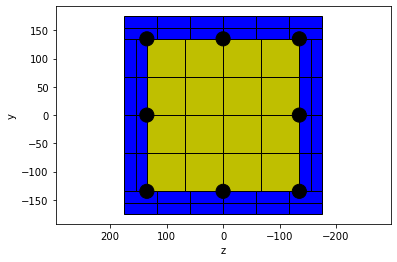

In [32]:
osv.plot_fiber_section(fibSec_1)
plt.axis('equal')

### Boundary Conditions

In [33]:
# === Boundary Conditions at the dof of each node (syntax - fix(nodeTag, * constrValues))
#   0  -  free and 1 - constrained

xRes =1 
yRes = 1 
RzRes = 1
os.fix(nodeTags[0], xRes, yRes, RzRes) # Fixed support at node 1 (i.e. two displacements (Dx and Dy) and one rotation (Rz))

### Recorder

In [34]:
# === Recorder Definition 
#     Recorder object is a mechanism to store the response (such as node displacements, node reaction, element section forces etc)
#     Recorder records the requested response quantity at each converged step
#     Lets record, the node displacement at top top free node and rection at the bottom node

os.recorder('Node', '-file', 'ReacDOF_c1.out','-node', nodeTags[0],'-dof',1,'reaction')
os.recorder('Node', '-file', 'DispDOF_c1.out','-node', nodeTags[-1],'-dof',1,'reaction')

7

### FE Model Visualization (Undeformed)

Text(0.5, 1.0, 'Undeformed Model')

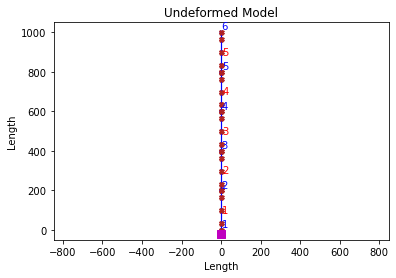

In [35]:
osv.plot_model()
plt.xlabel('Length')
plt.ylabel('Length')
plt.title('Undeformed Model')

## Analysis Setting and Incremental Analysis 

### Gravity Load

In [36]:
tsTag = 1 
patternTags = [1,2]     # 1 - for gravity load and 2 - for lateral load 
os.timeSeries("Linear", tsTag)  # linear time series
os.pattern("Plain", patternTags[0], tsTag)  # plain pattern 
os.load(nodeTags[-1],0.0,VLoad,0.0) # load definition 

os.constraints("Plain")    # Constrain handler, this handles how the constraints are enforced a dof 
os.numberer("RCM")         # Scheme to define thenumbering for degree of freedom. This command also set mappings between equation numbers and degree of freedom 
os.system('BandGeneral')   # Defines the system of equations 
os.test('NormDispIncr',1.0e-5,10)   # Convergence criteria at each iteration 
                                    # 10 is the maximum number of iterations to check before returning failure status \\
os.algorithm('Newton')     # Newton : this updates tanget stiffness at every iteration 

# === Integrator object formulates the Ax=B depending on the kinde of integrator specified 
#     Load control - Applies load in B vector 
#     Displacement control - applies displacement in x vector and reanrranges the system of equation Ax=B
#     And etc - depending on the kind of integrator sceheme, the system of equation (Ax=B) will be rearranged 
#     Also, the integrator object is responsible for applying the correct dt in (t+dt)

numSteps = 10 
dt = 1/numStep    
os.integrator ('LoadControl',dt)   # 0.1 is the load increment - this applies gravity in 10- steps

os.analysis('Static')      # define type of analysis static or transient 
gravityAnalysisStatus = os.analyze(numSteps)    # Runs one analysis step
                                                # Returns 0 if analysis is successful and < 0 if analysis is failed 
    

if (gravityAnalysisStatus == 0):
    print('Gravity analysis successful')
else:
    print('Gravity analysis failed!')

Gravity analysis successful


### Cyclic Lateral Load (Displacement Control)
1. The analysis under lateral loads is the so-called pushover analyis
2. This case uses displacement control integrator to perform pushover analysis 
3. The lateral load application wil start after completing the gravity load application ends. 
4. The load and response state at hte end of gravity analysis must be reatined in the lateral load analysis also, to achieve this we use a specia command called loadConst 


In [38]:
os.loadConst('-time',0.0)

In [ ]:
os.pattern("Plain", patternTags[1], tsTag)    # Plain pattern 
os.load(nodeTags[-1], HLoad, 0.0, 0.0) # Load definition 

os.wipeAnalysis()                 # Only deletes the previously defined analysis object in the model 
os.constraints("Plain")           # Constrain handler, this handles how the constraints are enforced at a dof 
os.numberer("RCM")                # Scheme to define the numbering for degree of freedoms. This command also sets mapping between equatin numbers and degree of freedom 
os.system('BandGeneral')   # Defines the system of equations 
os.test('NormDispIncr',1.0e-5,10)   # Convergence criteria at each iteration 
                                    # 10 is the maximum number of iterations to check before returning failure status \\
os.algorithm('Newton')     # Newton : this updates tanget stiffness at every iteration 

# === Integrator object formulates the Ax=B depending on the kinde of integrator specified 
#     Load control - Applies load in B vector 
#     Displacement control - applies displacement in x vector and reanrranges the system of equation Ax=B
#     And etc - depending on the kind of integrator sceheme, the system of equation (Ax=B) will be rearranged 
#     Also, the integrator object is responsible for applying the correct dt in (t+dt)

